# 7113095008 江宜娉 HW1 SVD

In [10]:
from PIL import Image
from ipywidgets import interact,interactive,interact_manual
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import math

# 圖片處理與轉換

左圖 : 彩色照片(橫)) 1 pixel > RGB 三個值 : [ 77  97 148]
Size : 19566000  = 2174 x 3000 x 3 

中圖 : 灰階照片 1 pixel > 灰階值 : 97
Size : 6522000  = 2174 x 3000 

右圖 : 彩色照片(直) 1 pixel > RGB 三個值 : [222 193 151]
Size : 36000000  = 4000 x 3000 x 3 



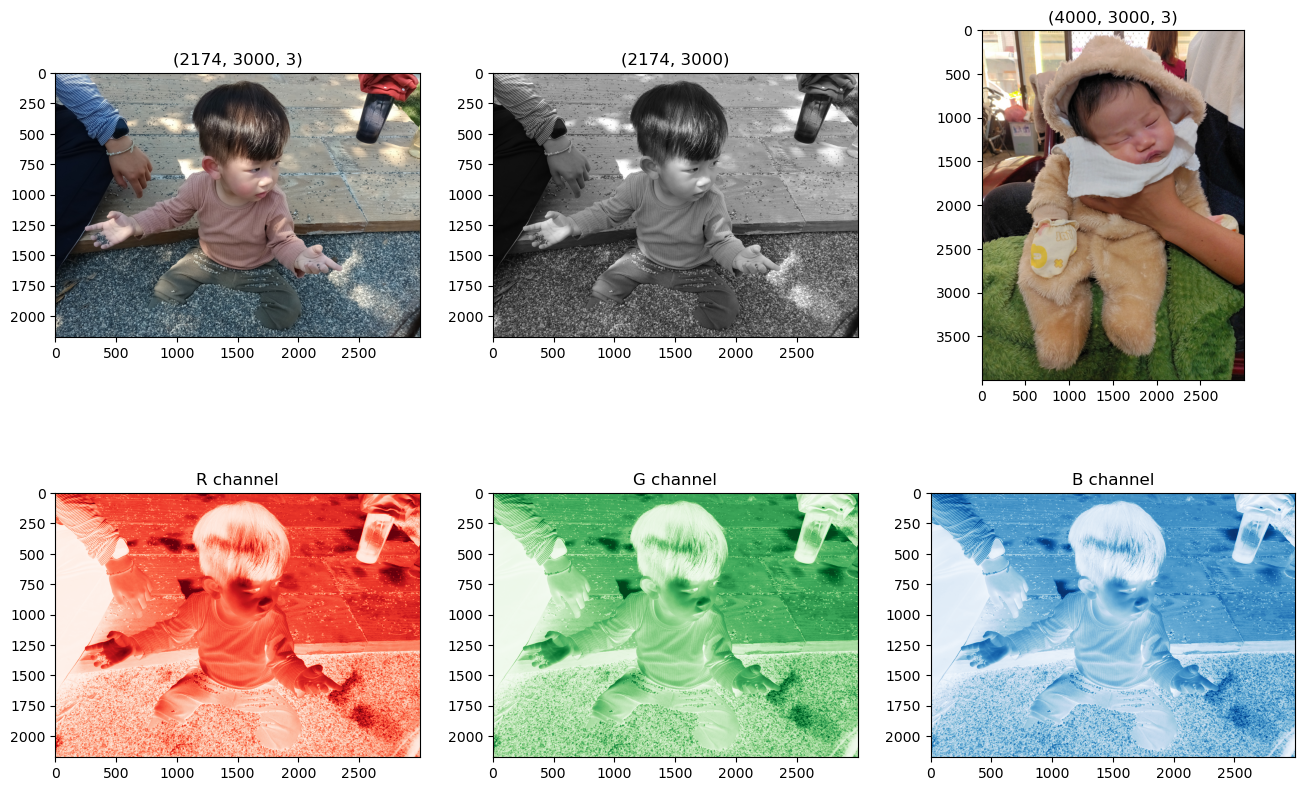

In [15]:
# 讀出一張RGB圖片(橫)
img_neveu = Image.open("neveu.jpg", "r")

# 將RGB圖片轉為矩陣表示
neveu = np.array(img_neveu)

# 將RGB圖片轉為灰階圖片
img_to_gray = Image.open("neveu.jpg").convert("L")
neveu_gray = np.array(img_to_gray)
img_gray = Image.fromarray(neveu_gray).save("neveu_gr.jpg")

# 讀出一張RGB圖片(直)
img_neveu_ver = Image.open("neveu_ver.jpg", "r")
neveu_ver = np.array(img_neveu_ver)

# 繪圖
plt.figure(figsize=(16 ,10))
plt.subplot(2,3,1)
plt.title(neveu.shape)
plt.imshow(neveu)
plt.subplot(2,3,2)
plt.title(neveu_gray.shape)
plt.imshow(neveu_gray, cmap="gray")
plt.subplot(2,3,3)
plt.title(neveu_ver.shape)
plt.imshow(neveu_ver)
plt.subplot(2,3,4)
plt.title("R channel")
plt.imshow(neveu[:,:,0], cmap="Reds")
plt.subplot(2,3,5)
plt.title("G channel")
plt.imshow(neveu[:,:,1], cmap="Greens")
plt.subplot(2,3,6)
plt.title("B channel")
plt.imshow(neveu[:,:,2], cmap="Blues")

# 顯示資訊
print("左圖 : 彩色照片(橫)) 1 pixel > RGB 三個值 :", neveu[0][0])
print("Size :", neveu.size, " =", neveu.shape[0], "x", neveu.shape[1], "x", neveu.shape[2], "\n")
print("中圖 : 灰階照片 1 pixel > 灰階值 :", neveu_gray[0][0])
print("Size :", neveu_gray.size, " =", neveu_gray.shape[0], "x", neveu_gray.shape[1], "\n")
print("右圖 : 彩色照片(直) 1 pixel > RGB 三個值 :", neveu_ver[0][0])
print("Size :", neveu_ver.size, " =", neveu_ver.shape[0], "x", neveu_ver.shape[1], "x", neveu_ver.shape[2], "\n")

# 7113095008 江宜娉 HW1 SVD

# 2-norm

In [16]:
# 2-norm
def norm2 (a, ak):
    return np.linalg.norm(a-ak, 2)

# mse 均方誤差

In [17]:
# mse 均方誤差
def mse (a, ak):
    m = np.mean((a/1.0 - ak/1.0) ** 2)
    return m

# Singular Value Decomposition (SVD)

In [18]:

# Singular Value Decomposition (SVD)
def svd_restore(image, k, rgb):

    # 對圖形矩陣做 SVD 分解 : u > mxm, sigma > m, v > mxn
    u, sigma, v = np.linalg.svd(image, full_matrices=False)

    # 避免 K 值超出 sigma > m 長度
    k = min(len(sigma)-1, k) 

    # 依照 k 值，得到新的圖形矩陣
    Ak  = np.dot(u[:,:k], np.dot(np.diag(sigma[:k]), v[:k,:]))

    # 計算原圖矩陣與新圖矩陣的 2-norm
    norm = norm2(image, Ak)

    # 計算原圖矩陣與新圖矩陣的 mse
    m = mse(image, Ak)

    # value 小於 0 > 改 0
    Ak[Ak < 0] = 0     
    
    # value 大於 255 > 改 255
    Ak[Ak > 255] = 255

    # 算出來為float，四捨五入取整數，轉型為圖片所需的 uint8
    Ak = np.rint(Ak).astype('uint8')

    return Ak, sigma, norm, sigma[k], m

## PSNR - 峰值訊噪比

In [39]:
# PSNR - 峰值訊噪比
def psnr(originalImg, sampleImg):
    # 確保輸入為浮點數以避免整數除法問題
    originalImg = originalImg.astype(np.float64)
    sampleImg = sampleImg.astype(np.float64)
    
    mse = np.mean((originalImg - sampleImg) ** 2)
    
    if mse < 1.0e-10:
        return float('inf')  # 當MSE接近0時返回無限大
    
    # 對於8位元圖片,最大像素值為255
    PIXEL_MAX = 255.0
    
    return 20 * math.log10(PIXEL_MAX) - 10 * math.log10(mse)

In [90]:
# 詳細資料圖表
def showTable(rangeArrK, info, fileName):

   table = np.zeros((15, 7))

   table[:,0] = rangeArrK.T
   table[:,1] = info[:,0]
   table[:,2] = info[:,1]
   table[:,3] = info[:,2]

   originalImage = cv2.imread(fileName + ".jpg")
   originalImageSize = round(os.stat(fileName + ".jpg").st_size/1024, 2)

   i = 0

   for item in rangeArrK:
      svdImg = cv2.imread("svd\\svd_" + fileName + "_" + str(item) + ".jpg")
      table[i,4] = psnr(originalImage, svdImg)
      table[i,5] = originalImageSize
      table[i,6] = round(os.stat("svd\\svd_" + fileName + "_" + str(item) + ".jpg").st_size/1024, 2)
      #table[i,7] = cr(originalImageSize, table[i,4])
      #table[i,8] = ss(originalImageSize, table[i,4])
      
      i += 1

   return table

# k值-正相關 SS MSE-負相關 SIZE PSNR
def showLinear(table, resize):
    # 創建圖表
    plt.figure(figsize=(24,8), dpi=50)
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 微軟正黑體
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
    
    # 第一個子圖 - MSE
    ax1 = plt.subplot(1,3,1)
    ax1.plot(table[:,0], table[:,3]/resize, 's-', 
             color='skyblue', label=f"MSE/{resize}")
    ax1.set_xlabel("k值", fontsize=30, labelpad=15)
    ax1.tick_params(axis='both', labelsize=20)
    ax1.legend(loc="best", fontsize=20)
    ax1.grid(True)  # 添加網格線
    
    # 第二個子圖 - SIZE
    ax2 = plt.subplot(1,3,2)
    ax2.plot(table[:,0], table[:,6], 's-', 
             color='green', label="SIZE")
    ax2.set_xlabel("k值", fontsize=30, labelpad=15)
    ax2.tick_params(axis='both', labelsize=20)
    ax2.legend(loc="best", fontsize=20)
    ax2.grid(True)  # 添加網格線
    
    # 第三個子圖 - PSNR
    ax3 = plt.subplot(1,3,3)
    ax3.plot(table[:,0], table[:,4], 's-', 
             color='blue', label="PSNR")
    ax3.set_xlabel("k值", fontsize=30, labelpad=15)
    ax3.tick_params(axis='both', labelsize=20)
    ax3.legend(loc="best", fontsize=20)
    ax3.grid(True)  # 添加網格線
    
    # 調整子圖之間的間距
    plt.tight_layout()
    
    plt.show()

# 可動態調整k值-灰階
def compress_show_gray_images(k):
    # 進行SVD重建
    image = neveu_gray
    reconst_img, sigma, norm, sigmak1, m = svd_restore(image, k, "灰階")
    
    # 創建單一圖表
    plt.figure(figsize=(5,5))  # 調整為單一圖的大小
    # 顯示重建後的圖片
    plt.imshow(reconst_img, cmap='gray')
    plt.axis('off')  # 關閉座標軸顯示
    plt.tight_layout()

# 可動態調整k值-彩色-resharp
def compress_show_color_images_reshape(k):
    image = neveu
    original_shape = image.shape
    image_reshaped = image.reshape((original_shape[0],original_shape[1]*3))
    image_reconst, sigma, norm, sigmak1, m = svd_restore(image_reshaped, k, "灰階")
    image_reconst = image_reconst.reshape(original_shape)
    fig,axes = plt.subplots(1,2,figsize=(8,5))
    axes[0].plot(sigma)
    axes[0].set_xlabel("k值", fontsize=12, labelpad = 15)
    axes[0].set_ylabel("sigma值", fontsize=12, labelpad = 20)
    axes[1].imshow(image_reconst,cmap='gray')
    axes[1].axis('off')
    fig.tight_layout()

# 可動態調整k值-彩色-layer
def compress_show_color_images_layer(k):
    image = neveu_ver
    original_shape = image.shape
    image_reconst = np.zeros(original_shape)
    R, sigmaR, norm, sigmak1, m = svd_restore(image[:, :, 0], k, "R")
    G, sigmaG, norm, sigmak1, m = svd_restore(image[:, :, 1], k, "G")
    B, sigmaB, norm, sigmak1, m = svd_restore(image[:, :, 2], k, "B")
    sigma = (sigmaR+sigmaG+sigmaB)/3
    image_reconst = np.dstack((R, G, B))
    fig,axes = plt.subplots(1,2,figsize=(8,5))
    axes[0].plot(sigma)
    axes[0].set_xlabel("k值", fontsize=12, labelpad = 15)
    axes[0].set_ylabel("sigma值", fontsize=12, labelpad = 20)
    axes[1].imshow(image_reconst)
    axes[1].axis('off')
    fig.tight_layout()

# 設定 0 < K < 3000 (0 ~ 2999)

In [75]:
# K值範圍
rangeArrK = np.array([1, 5, 10, 20, 50, 100, 200, 350, 500, 800, 1000, 1500, 2000, 2500, 3000])

# 需要呈現的統計特徵
feature_names = np.array(["K值", "2-norm", "sigma k+1", "均方誤差(MSE)", "峰值訊噪比(PSNR)", "原圖大小(Kb)", "圖片大小(Kb)"])

# 依照不同K值對灰階圖片進行壓縮

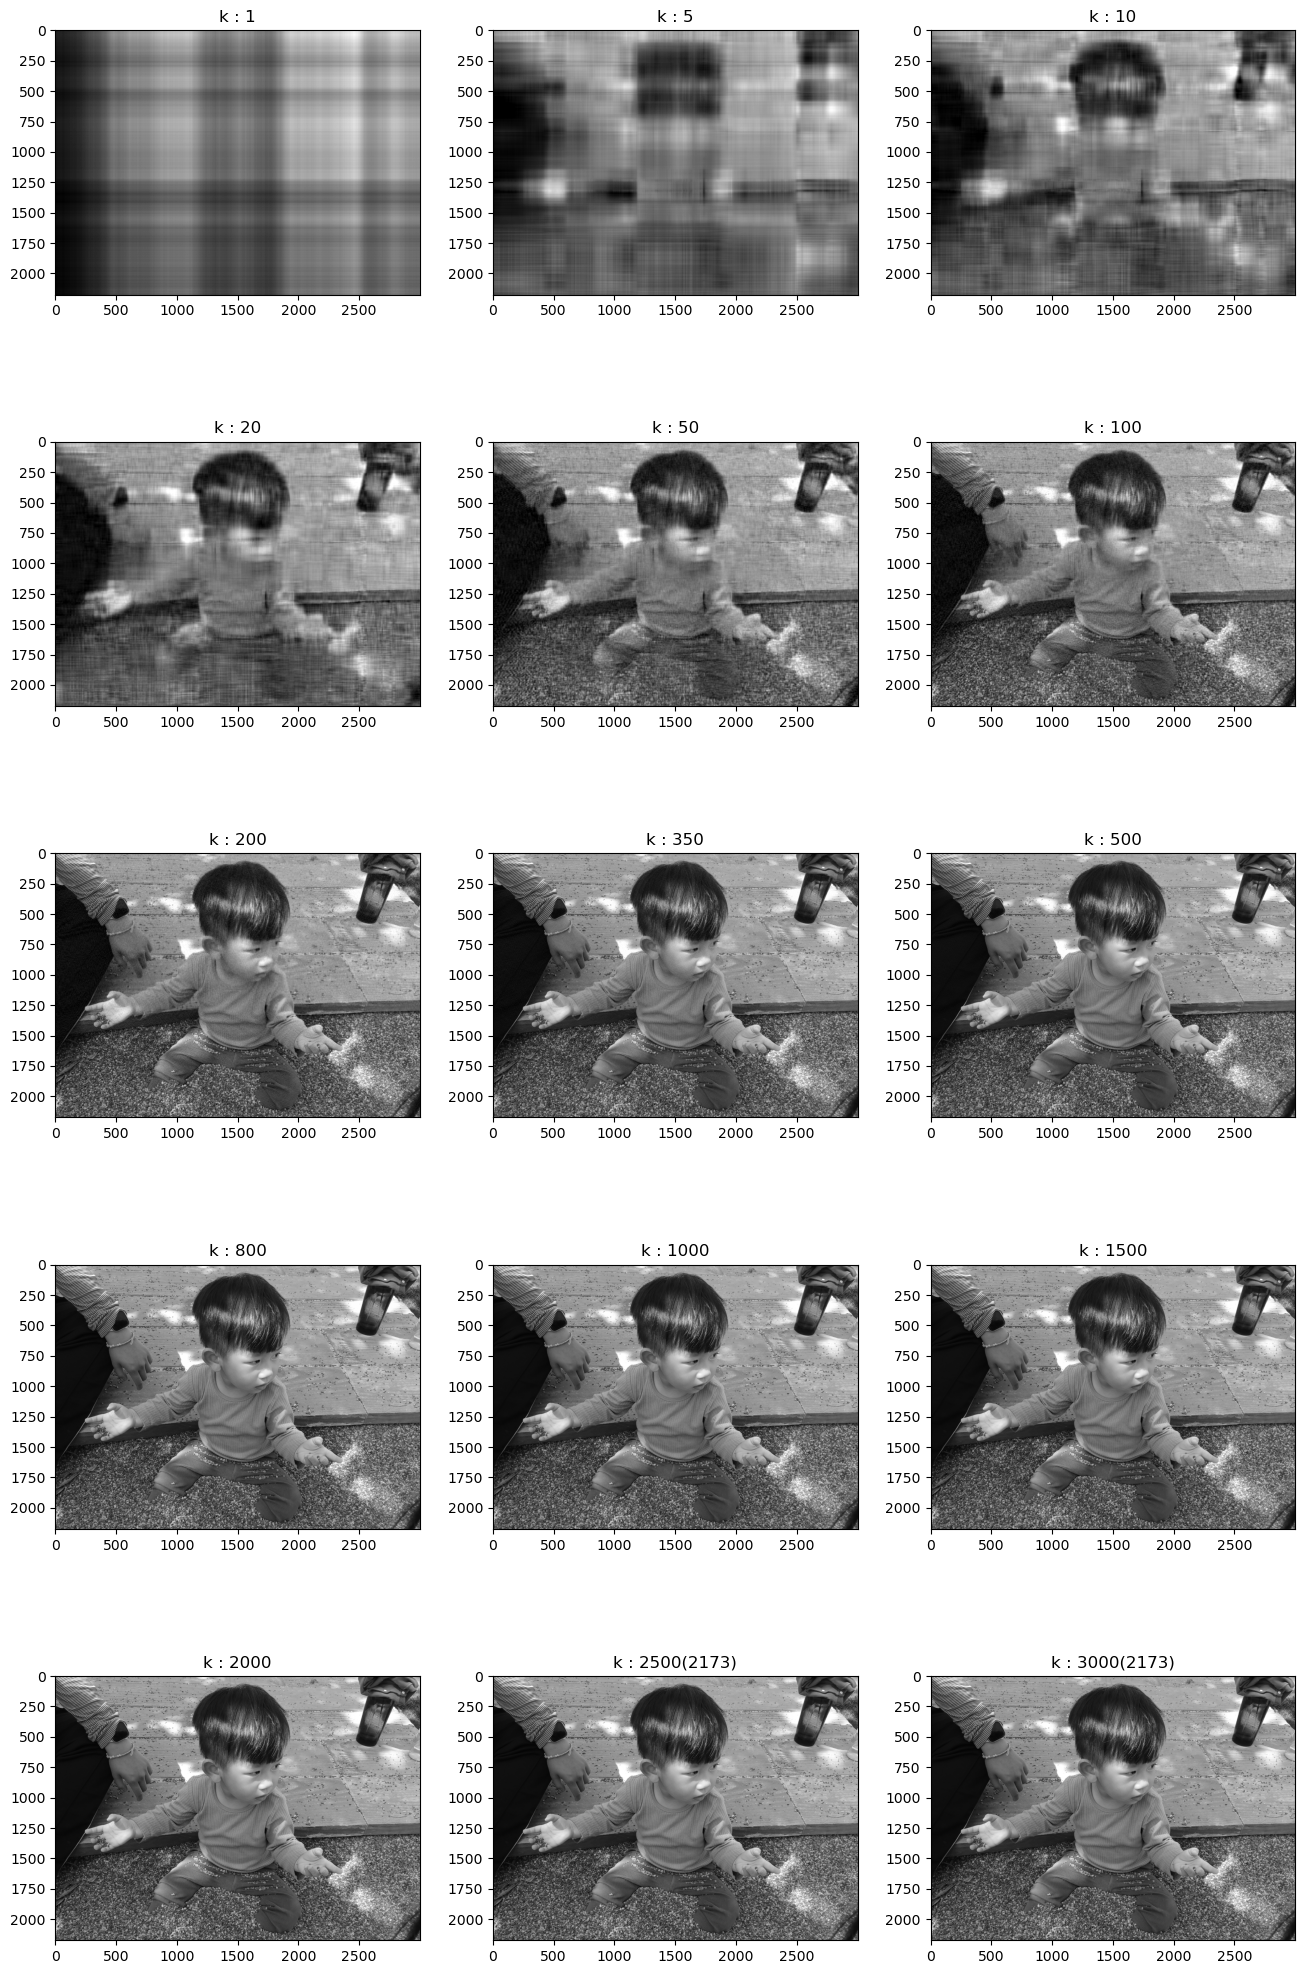

In [37]:
plt.figure(figsize=(16, 24))

p = 0

garyInfoTempTable = np.zeros((15, 3))

for k in rangeArrK:

    # 灰階圖的SVD分解
    
    G, sigma, norm, sigmak1, m = svd_restore(neveu_gray, k, "灰階")

    garyInfoTempTable[p,0] = norm
    garyInfoTempTable[p,1] = sigmak1
    garyInfoTempTable[p,2] = m

    # 將壓縮過的圖片存在 svd 文件夾下

    Image.fromarray(G).save("svd\\svd_neveu_gr_" + str(k) + ".jpg")

    # 透過 plt 顯示出來

    p += 1
    plt.subplot(5,3,p)

    sigmaLen = len(sigma)-1
    title = "k : " + str(k) + "(" + str(sigmaLen) + ")" if k > len(sigma)-1 else "k : " + str(k)

    plt.title(title)
    plt.imshow(G, cmap="gray")

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.show()

# MSE與K值負相關 
# SIZE、PSNR與K值正相關

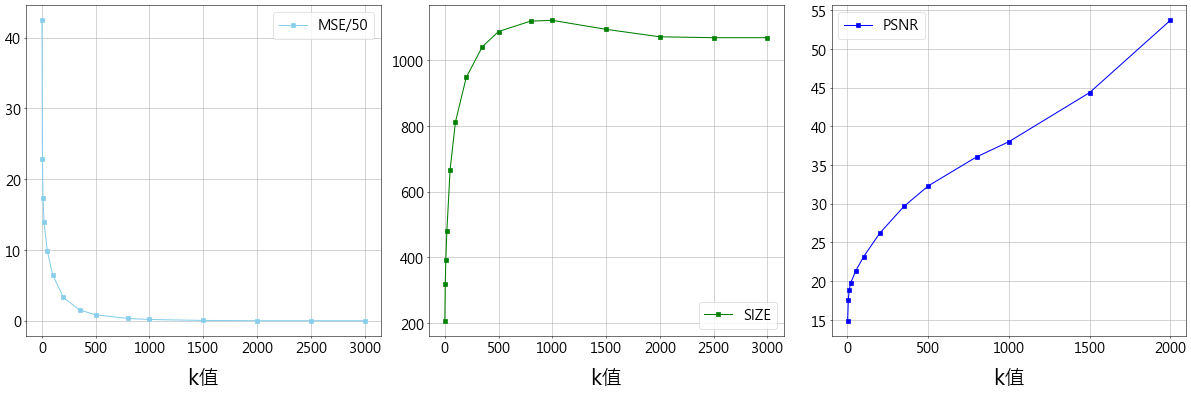

K值        2-norm     sigma k+1    均方誤差(MSE)  峰值訊噪比(PSNR)  原圖大小(Kb)  \
0      1.0  52293.650118  52293.650118  2122.561894    14.888317   1067.93   
1      5.0  25570.324893  25570.324893  1145.742773    17.591332   1067.93   
2     10.0  14195.635103  14195.635103   867.179825    18.816135   1067.93   
3     20.0   8153.680864   8153.680864   695.836288    19.785005   1067.93   
4     50.0   5490.910484   5490.910484   495.906764    21.282705   1067.93   
5    100.0   4064.066448   4064.066448   324.199932    23.172748   1067.93   
6    200.0   2528.085542   2528.085542   164.603834    26.201542   1067.93   
7    350.0   1484.197022   1484.197022    75.973511    29.666039   1067.93   
8    500.0    996.857554    996.857554    41.628125    32.305663   1067.93   
9    800.0    552.929735    552.929735    15.790057    36.060707   1067.93   
10  1000.0    408.409047    408.409047     8.799335    38.023396   1067.93   
11  1500.0    208.124147    208.124147     1.742856    44.366791   1067.93   
12  2000.0     80.828215     80.828215     0.102530    53.705876   1067.93   
13  2500.0     36.090744     36.090744     0.000200          inf   1067.93   
14  3000.0     36.090744     36.090744     0.000200          inf   1067.93   

    圖片大小(Kb)  
0     207.92  
1     318.14  
2     391.06  
3     481.47  
4     666.55  
5     812.39  
6     947.12  
7    1040.59  
8    1086.67  
9    1118.44  
10   1120.60  
11   1093.32  
12   1070.60  
13   1067.93  
14   1067.93

In [85]:
garyResult = showTable(rangeArrK, garyInfoTempTable, "neveu_gr")
showLinear(garyResult, 50)
pd.DataFrame(garyResult, columns=feature_names)


# 拖曳K值檢視壓縮黑白圖像的效果

In [92]:
interact(compress_show_gray_images,k=(1,1000))

interactive(children=(IntSlider(value=500, description='k', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.compress_show_gray_images(k)>

# 依照不同k值對彩色圖片進行壓縮 

## 1. Reshape method > 先將三維變二維，二維做完svd，再變回三維 > 彩色圖片(橫)

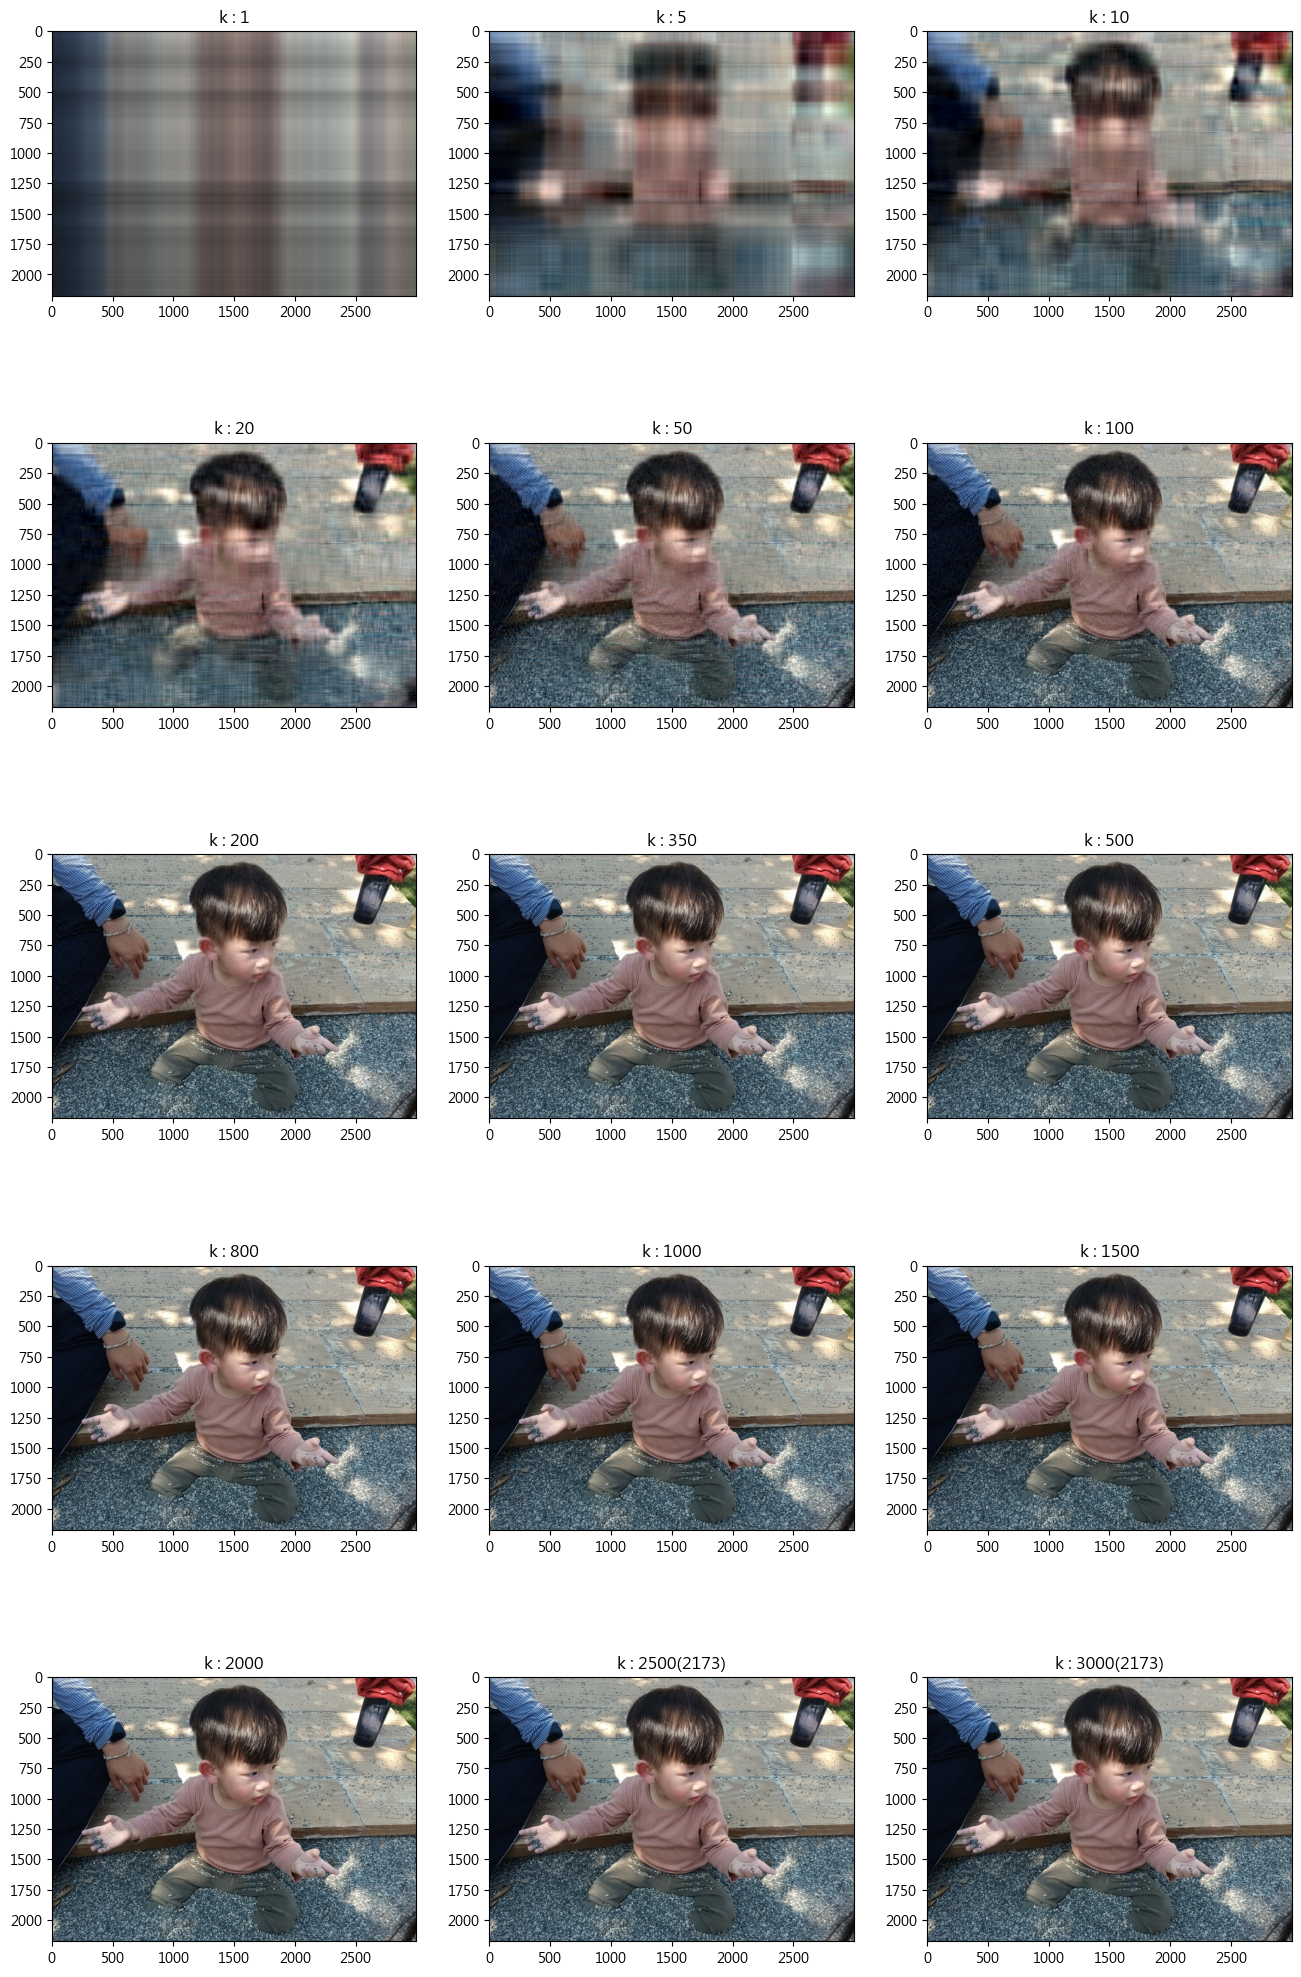

In [96]:
plt.figure(figsize=(16,24))

p = 0

infoTempTable = np.zeros((15, 3))

for k in rangeArrK:

    # Reshape method
    
    original_shape = neveu.shape
    image_reshaped = neveu.reshape((original_shape[0], original_shape[1] * original_shape[2]))
    image_reconst, sigma, norm, sigmak1, m = svd_restore(image_reshaped, k, "灰階")
    image_reconst = image_reconst.reshape(original_shape)

    infoTempTable[p,0] = norm
    infoTempTable[p,1] = sigmak1
    infoTempTable[p,2] = m

    # 將壓縮過的圖片存在 svd 文件夾下
    Image.fromarray(image_reconst).save("svd\\svd_neveu_" + str(k) + ".jpg")

    # 透過 plt 顯示出來
    p += 1
    plt.subplot(5, 3, p)

    sigmaLen = len(sigma)-1
    title = "k : " + str(k) + "(" + str(sigmaLen) + ")" if k > len(sigma)-1 else "k : " + str(k)

    plt.title(title)
    plt.imshow(image_reconst)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.show()

# MSE與K值負相關 
# SIZE、PSNR與K值正相關

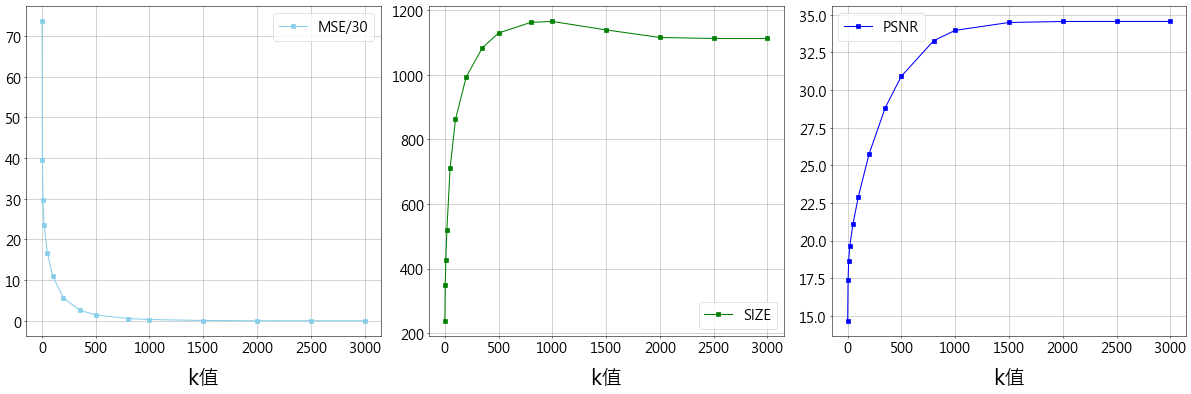

K值        2-norm     sigma k+1    均方誤差(MSE)  峰值訊噪比(PSNR)  原圖大小(Kb)  \
0      1.0  92291.347675  92291.347675  2208.362374    14.687349   3415.35   
1      5.0  44795.746905  44795.746905  1185.320346    17.391391   3415.35   
2     10.0  25113.246786  25113.246786   887.281792    18.647548   3415.35   
3     20.0  14516.715540  14516.715540   707.181414    19.627508   3415.35   
4     50.0   9560.577130   9560.577130   503.300653    21.098549   3415.35   
5    100.0   7017.066325   7017.066325   330.043482    22.915737   3415.35   
6    200.0   4417.108682   4417.108682   168.571695    25.755786   3415.35   
7    350.0   2609.655572   2609.655572    78.118573    28.825110   3415.35   
8    500.0   1749.209178   1749.209178    42.899431    30.921996   3415.35   
9    800.0    971.462684    971.462684    16.357296    33.276433   3415.35   
10  1000.0    717.781223    717.781223     9.163128    33.966659   3415.35   
11  1500.0    368.504657    368.504657     1.865591    34.488463   3415.35   
12  2000.0    148.872682    148.872682     0.119081    34.555996   3415.35   
13  2500.0     70.939996     70.939996     0.000257    34.558576   3415.35   
14  3000.0     70.939996     70.939996     0.000257    34.558576   3415.35   

    圖片大小(Kb)  
0     238.45  
1     350.43  
2     427.01  
3     518.90  
4     711.27  
5     861.92  
6     993.85  
7    1083.68  
8    1129.34  
9    1162.39  
10   1165.32  
11   1139.16  
12   1115.71  
13   1112.53  
14   1112.53

In [97]:
rgbResult = showTable(rangeArrK, infoTempTable, "neveu")
showLinear(rgbResult, 30)
pd.DataFrame(rgbResult, columns=feature_names)

# 拖曳K值檢視壓縮彩色圖像的效果

In [98]:
interact(compress_show_color_images_reshape,k=(1,1000))

interactive(children=(IntSlider(value=500, description='k', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.compress_show_color_images_reshape(k)>

## 2. Layers method > 分別對二維的R圖、G圖、B圖各自做svd，再把三張圖合起來 > 彩色圖片(直)

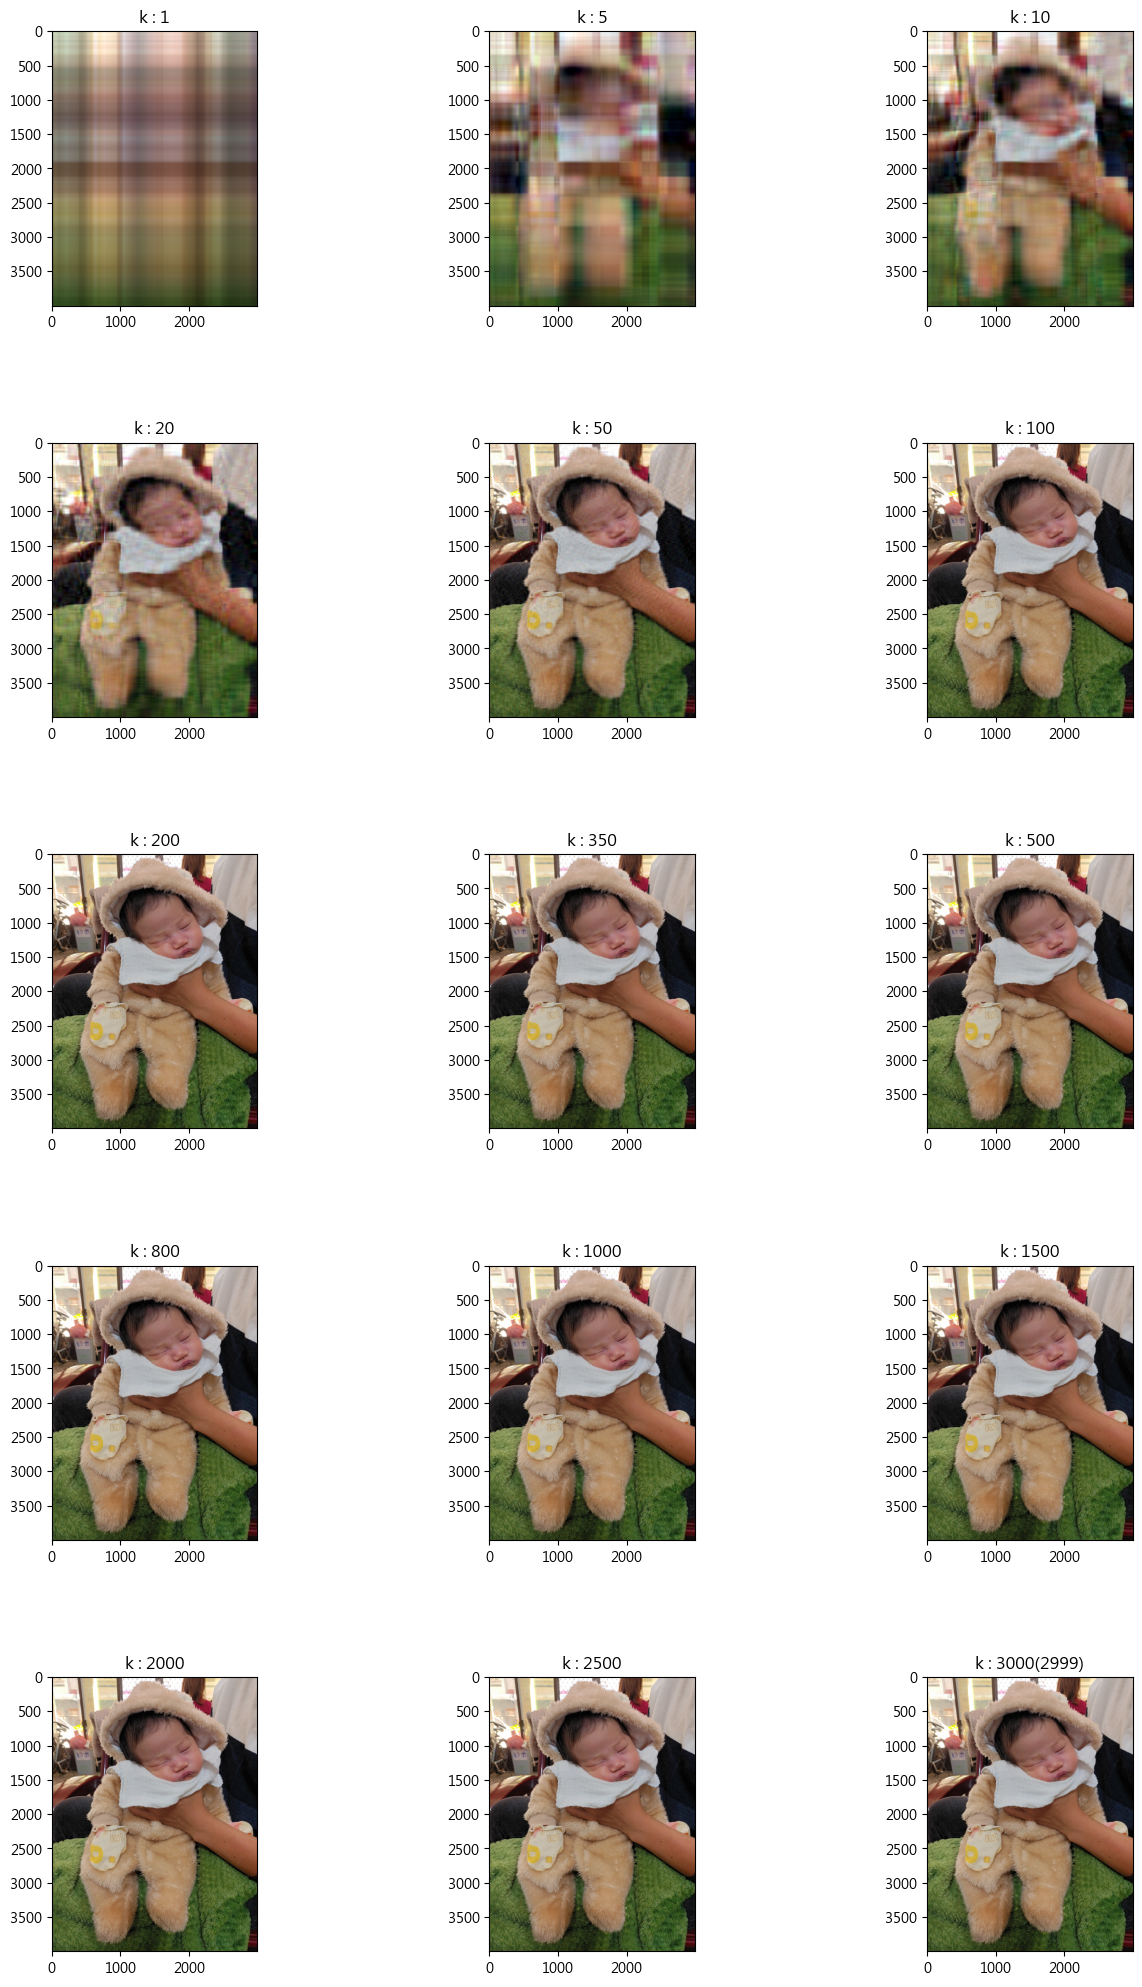

In [99]:
plt.figure(figsize=(16,24))

p = 0

verInfoTempTable = np.zeros((15, 3))

for k in rangeArrK:

    # R的SVD分解
    R, sigma, normR, sigmak1R, mR = svd_restore(neveu_ver[:, :, 0], k, "R")

    # G的SVD分解  
    G, sigma, normG, sigmak1G, mG = svd_restore(neveu_ver[:, :, 1], k, "G")

    # B的SVD分解     
    B, sigma, normB, sigmak1B, mB = svd_restore(neveu_ver[:, :, 2], k, "B")

    verInfoTempTable[p,0] = (normR+normG+normB)/3
    verInfoTempTable[p,1] = (sigmak1R+sigmak1G+sigmak1B)/3
    verInfoTempTable[p,2] = (mR+mG+mB)/3

    # 壓縮後的 RGB 組合一張圖    
    I = np.dstack((R, G, B))

    # 將壓縮過的圖片存在 svd 文件夾下
    Image.fromarray(I).save("svd\\svd_neveu_ver_" + str(k) + ".jpg")

    # 透過 plt 顯示出來
    p += 1
    plt.subplot(5,3,p)

    sigmaLen = len(sigma)-1
    title = "k : " + str(k) + "(" + str(sigmaLen) + ")" if k > len(sigma)-1 else "k : " + str(k)
    
    plt.title(title)
    plt.imshow(I)

plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
plt.show()

# MSE與K值負相關 
# SIZE、PSNR與K值正相關

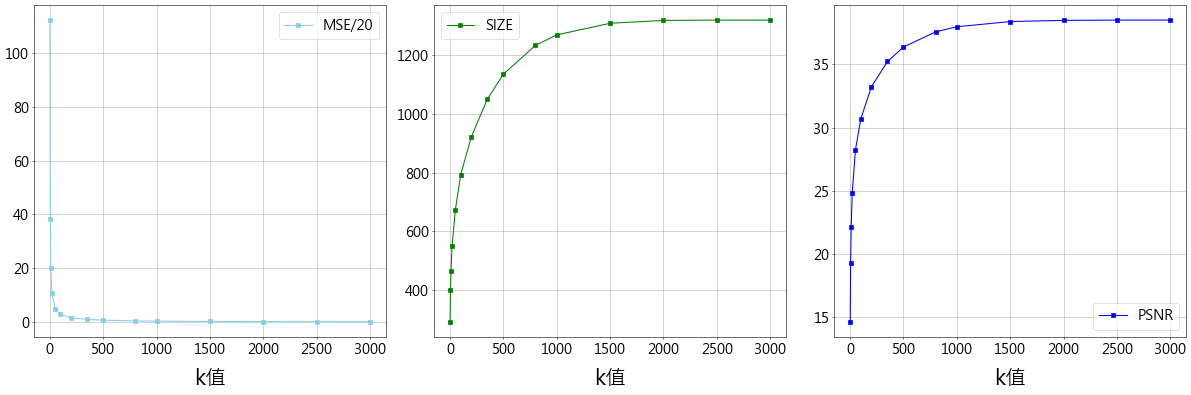

K值        2-norm     sigma k+1    均方誤差(MSE)  峰值訊噪比(PSNR)  原圖大小(Kb)  \
0      1.0  97517.645344  97517.645344  2246.388523    14.615141    5743.8   
1      5.0  36043.905000  36043.905000   767.618892    19.283508    5743.8   
2     10.0  20242.495136  20242.495136   401.474859    22.102544    5743.8   
3     20.0  10632.551983  10632.551983   214.106509    24.824118    5743.8   
4     50.0   4296.599653   4296.599653    96.616071    28.233216    5743.8   
5    100.0   2370.361416   2370.361416    54.210974    30.677037    5743.8   
6    200.0   1285.622523   1285.622523    28.852934    33.234677    5743.8   
7    350.0    779.250407    779.250407    16.391245    35.235580    5743.8   
8    500.0    566.872360    566.872360    10.874526    36.376452    5743.8   
9    800.0    374.957496    374.957496     5.566069    37.580662    5743.8   
10  1000.0    301.803727    301.803727     3.671307    37.986247    5743.8   
11  1500.0    185.394018    185.394018     1.250416    38.397659    5743.8   
12  2000.0    109.902322    109.902322     0.350005    38.491046    5743.8   
13  2500.0     56.706875     56.706875     0.061550    38.513253    5743.8   
14  3000.0     15.835568     15.835568     0.000021    38.514998    5743.8   

    圖片大小(Kb)  
0     293.86  
1     401.47  
2     466.74  
3     549.00  
4     671.34  
5     791.38  
6     920.78  
7    1048.99  
8    1133.60  
9    1231.44  
10   1267.15  
11   1306.66  
12   1316.31  
13   1317.51  
14   1317.41

In [100]:
verResult = showTable(rangeArrK, verInfoTempTable, "neveu_ver")
showLinear(verResult, 20)
pd.DataFrame(verResult, columns=feature_names)

In [101]:
interact(compress_show_color_images_layer,k=(1,1000))

interactive(children=(IntSlider(value=500, description='k', max=1000, min=1), Output()), _dom_classes=('widget…

<function __main__.compress_show_color_images_layer(k)>